In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set up directories

In [3]:
from pathlib import Path
data_root = Path.home() / "data" / "tmp"
sample_dir = data_root / "cats_vs_dogs_sample"
model_dir = data_root / "models"

# Create test sample generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        str(sample_dir / "test"),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Using plaidml.keras.backend backend.


Found 1000 images belonging to 2 classes.


# Evaluation

In [5]:
from keras.models import load_model

## Small convnet trained from scratch

In [6]:
%%time
fs_model = load_model(str(model_dir / "cats_and_dogs_small_from_scratch.h5"))
test_loss, test_acc = fs_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

INFO:plaidml:Opening device "metal_amd_radeon_pro_460.0"


test acc : 0.74
test loss: 0.92
CPU times: user 6.47 s, sys: 729 ms, total: 7.2 s
Wall time: 7.67 s


## Same small convnet but with data augmentation to prevent overfitting

In [7]:
%%time
fswa_model = load_model(str(model_dir / "cats_and_dogs_small_with_augmentation.h5"))
test_loss, test_acc = fswa_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

test acc : 0.82
test loss: 0.44
CPU times: user 5.77 s, sys: 508 ms, total: 6.28 s
Wall time: 6.31 s


## Use vgg16 to extract feature and then train a small dense model

In [8]:
import numpy as np

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(conv_base, directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        if ((i + 1) * batch_size) >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [10]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
test_features, test_labels = extract_features(conv_base, str(sample_dir / "test"), 1000)
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 1000 images belonging to 2 classes.


INFO:plaidml:Analyzing Ops: 79 of 144 operations complete


In [11]:
%%time
fe_model = load_model(str(model_dir / "cats_and_dogs_feature_extraction.h5"))
test_loss, test_acc = fe_model.evaluate(test_features, test_labels)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

1000/1000 [==============================] - 1s 657us/step
test acc : 0.89
test loss: 0.25
CPU times: user 215 ms, sys: 170 ms, total: 385 ms
Wall time: 859 ms


## Train a dense model on top of vgg16 with augmentation

In [12]:
%%time
fewa_model = load_model(str(model_dir / "cats_and_dogs_feature_extraction2.h5"))
test_loss, test_acc = fewa_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

/Users/jochen/miniconda3/envs/ds_tutorial/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
INFO:plaidml:Analyzing Ops: 63 of 190 operations complete


test acc : 0.88
test loss: 0.28
CPU times: user 9.65 s, sys: 1.22 s, total: 10.9 s
Wall time: 33.3 s


## Retrain the top layers of vgg16

In [13]:
ft_model = load_model(str(model_dir / "cats_and_dogs_fine_tuning.h5"))

In [14]:
%%time
ft_model = load_model(str(model_dir / "cats_and_dogs_fine_tuning.h5"))
test_loss, test_acc = ft_model.evaluate_generator(test_generator, steps=50)
print(f"test acc : {test_acc:.2f}")
print(f"test loss: {test_loss:.2f}")

test acc : 0.95
test loss: 0.31
CPU times: user 6.68 s, sys: 1.1 s, total: 7.79 s
Wall time: 26.6 s


# Show results of test images

In [15]:
import pandas as pd

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

In [16]:
models = {
    "from scratch": fs_model,
    "with augmentation": fswa_model,
    "feature extraction": fe_model,
    "fe with augmentation": fewa_model,
    "fine tuning": ft_model,
}

### Monkey patch feature extraction model to first use conv_base to extract features

In [17]:
fe_model.orig_predict = fe_model.predict

def monkey_predict(self, image_features):
    features = (conv_base.predict(image_features)
                .reshape(image_features.shape[0], 4 * 4 * 512))
    return self.orig_predict(features)

fe_model.predict = monkey_predict.__get__(fe_model, type(fe_model))

## Single test images

In [52]:
#img_name = "portokatze.jpg"
#img_name = "hund_porto.jpg"
img_name = "hund_thailand.jpg"
#img_name = "routerkatze.jpg"
img_path = str(Path(".") / ".." / ".." / "images" / img_name)

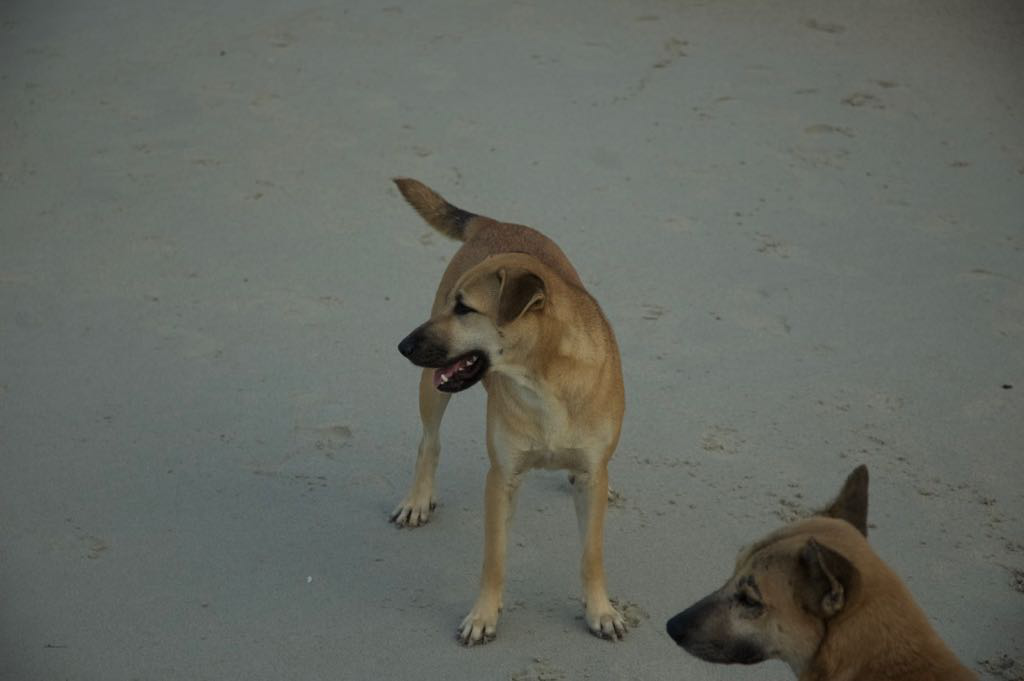

In [53]:
load_img(img_path)

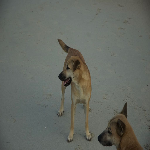

In [54]:
image = load_img(img_path, target_size=(150, 150))
image

In [55]:
image = img_to_array(image)
image_features = image.reshape((1, *image.shape)) * 1./255

In [56]:
print("Predictions:")
print("--------------------------------")
for name, model in models.items():
    proba = model.predict(image_features)[0][0]
    if proba >= 0.5:
        class_name = "dog"
    else:
        class_name = "cat"
        proba = 1. - proba
    print(f"{name}".ljust(21), f": {class_name} {proba:.2f}")

Predictions:
--------------------------------
from scratch          : cat 0.81
with augmentation     : cat 0.66
feature extraction    : dog 0.92
fe with augmentation  : dog 0.80
fine tuning           : dog 0.99


# Evaluate on some test images

In [34]:
num_samples = 9
base_num = 1500
cat_image_paths, dog_image_paths = [], []
for i in range(num_samples):
    img_num = base_num + i
    img_path = sample_dir / "test" / "cats" / f"cat.{img_num}.jpg"
    cat_image_paths.append(str(img_path))
    img_path = sample_dir / "test" / "dogs" / f"dog.{img_num}.jpg"
    dog_image_paths.append(str(img_path))

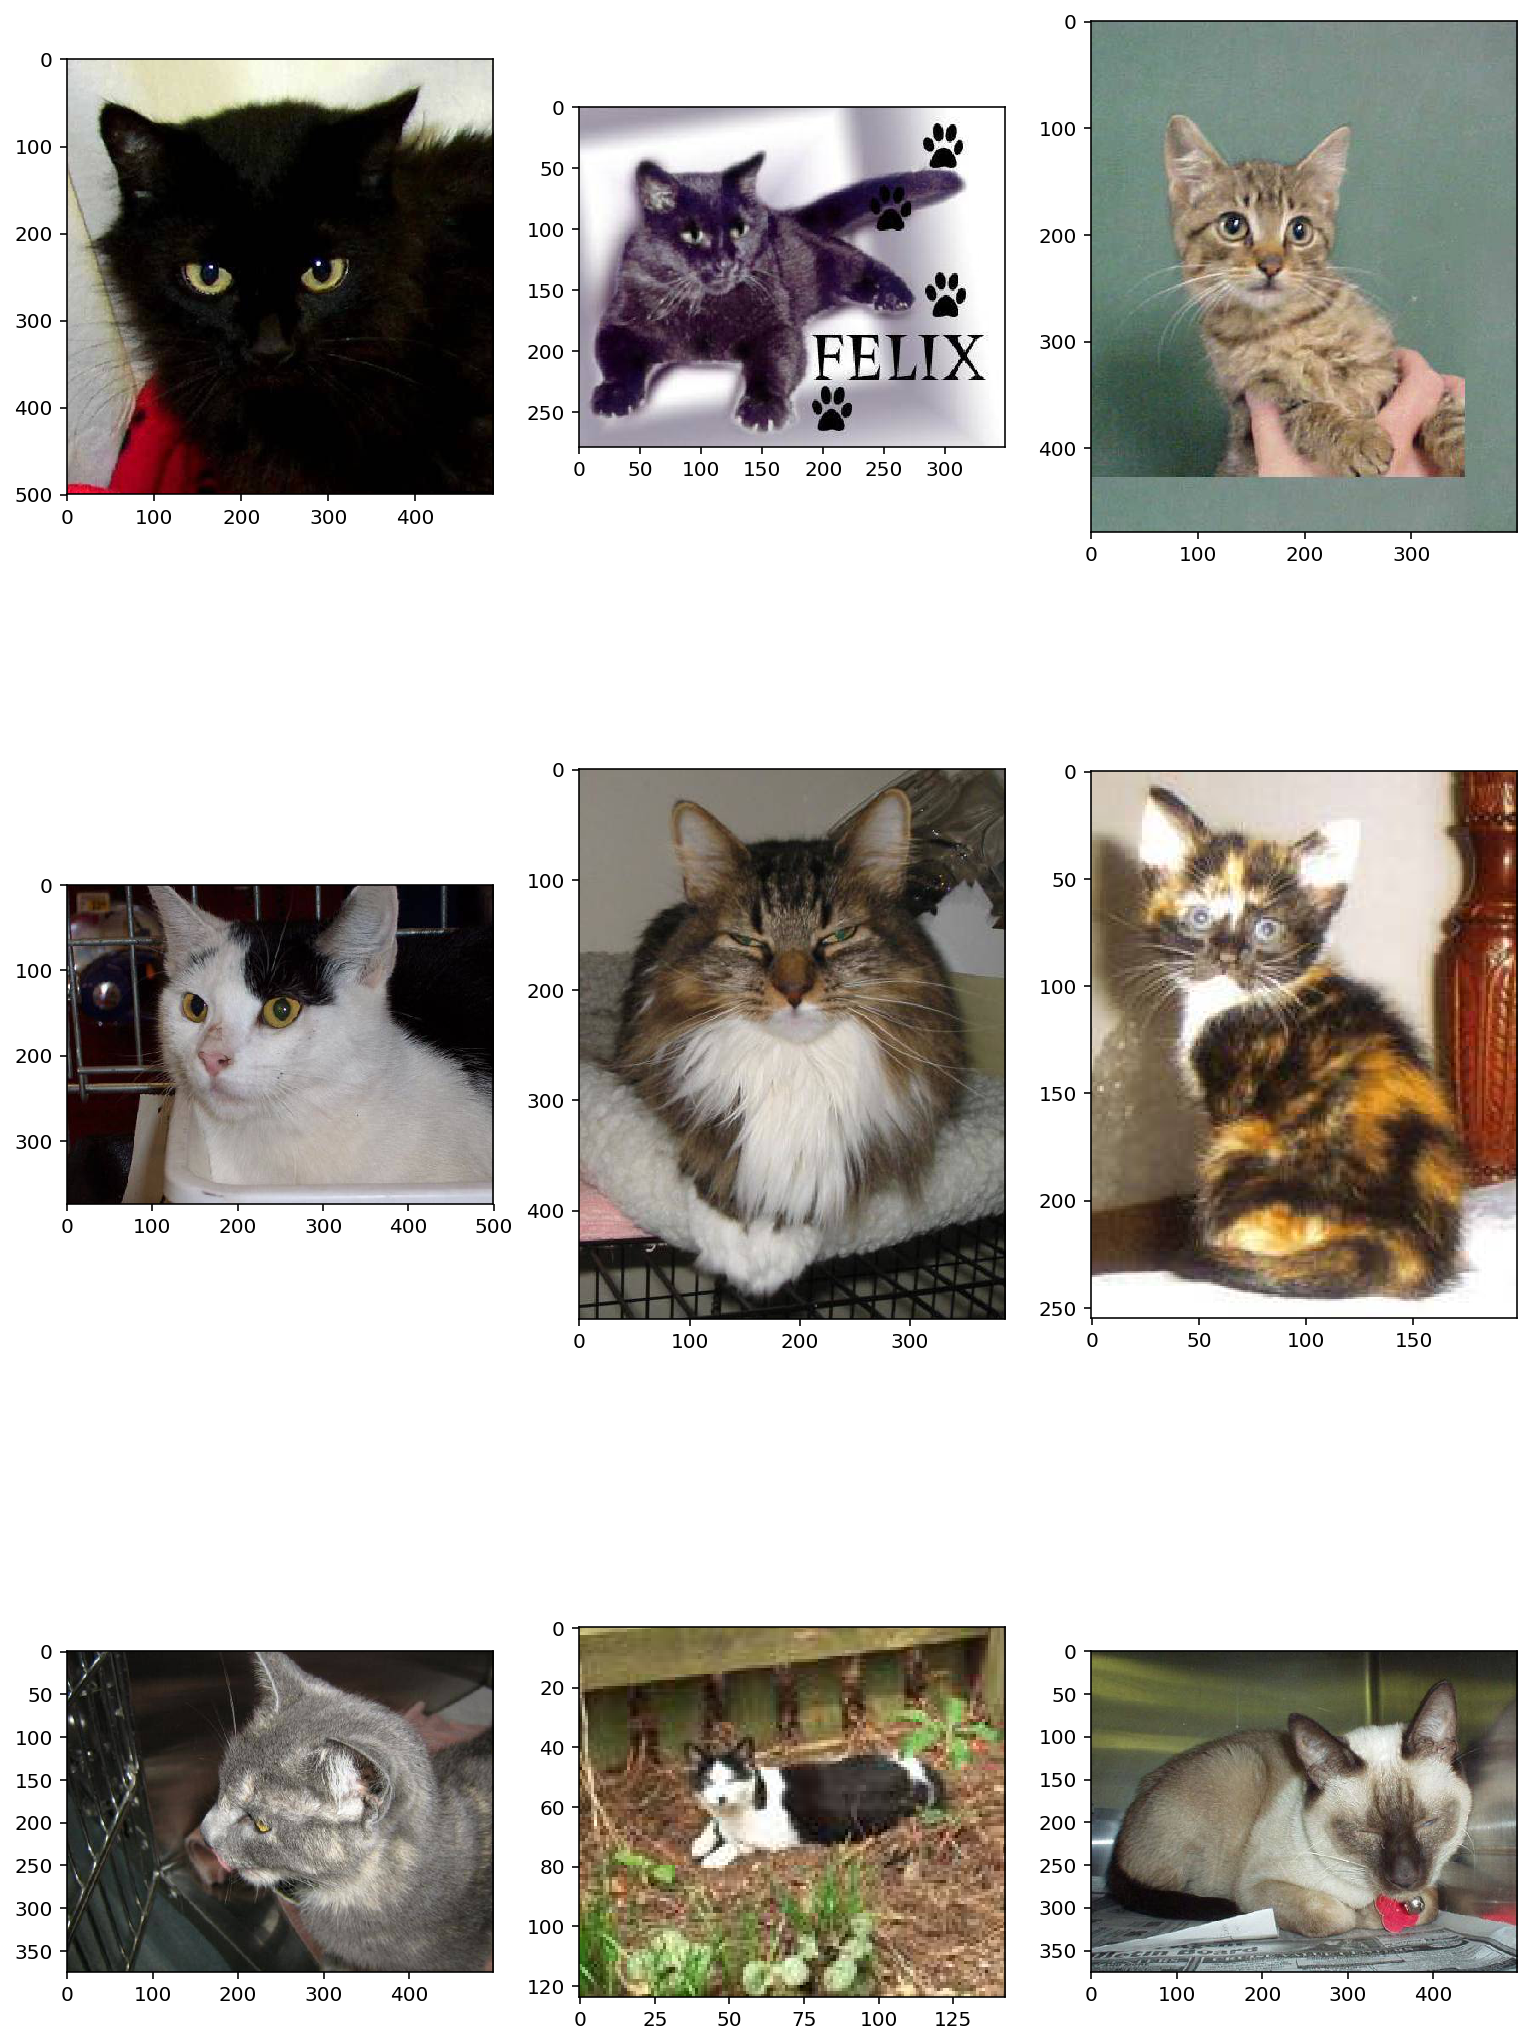

In [35]:
plt.figure(1, figsize=(13, 20))
for i, img_path in enumerate(cat_image_paths, 1):
    plt.subplot(3, 3, i)
    imgplot = plt.imshow(load_img(img_path))

plt.show()

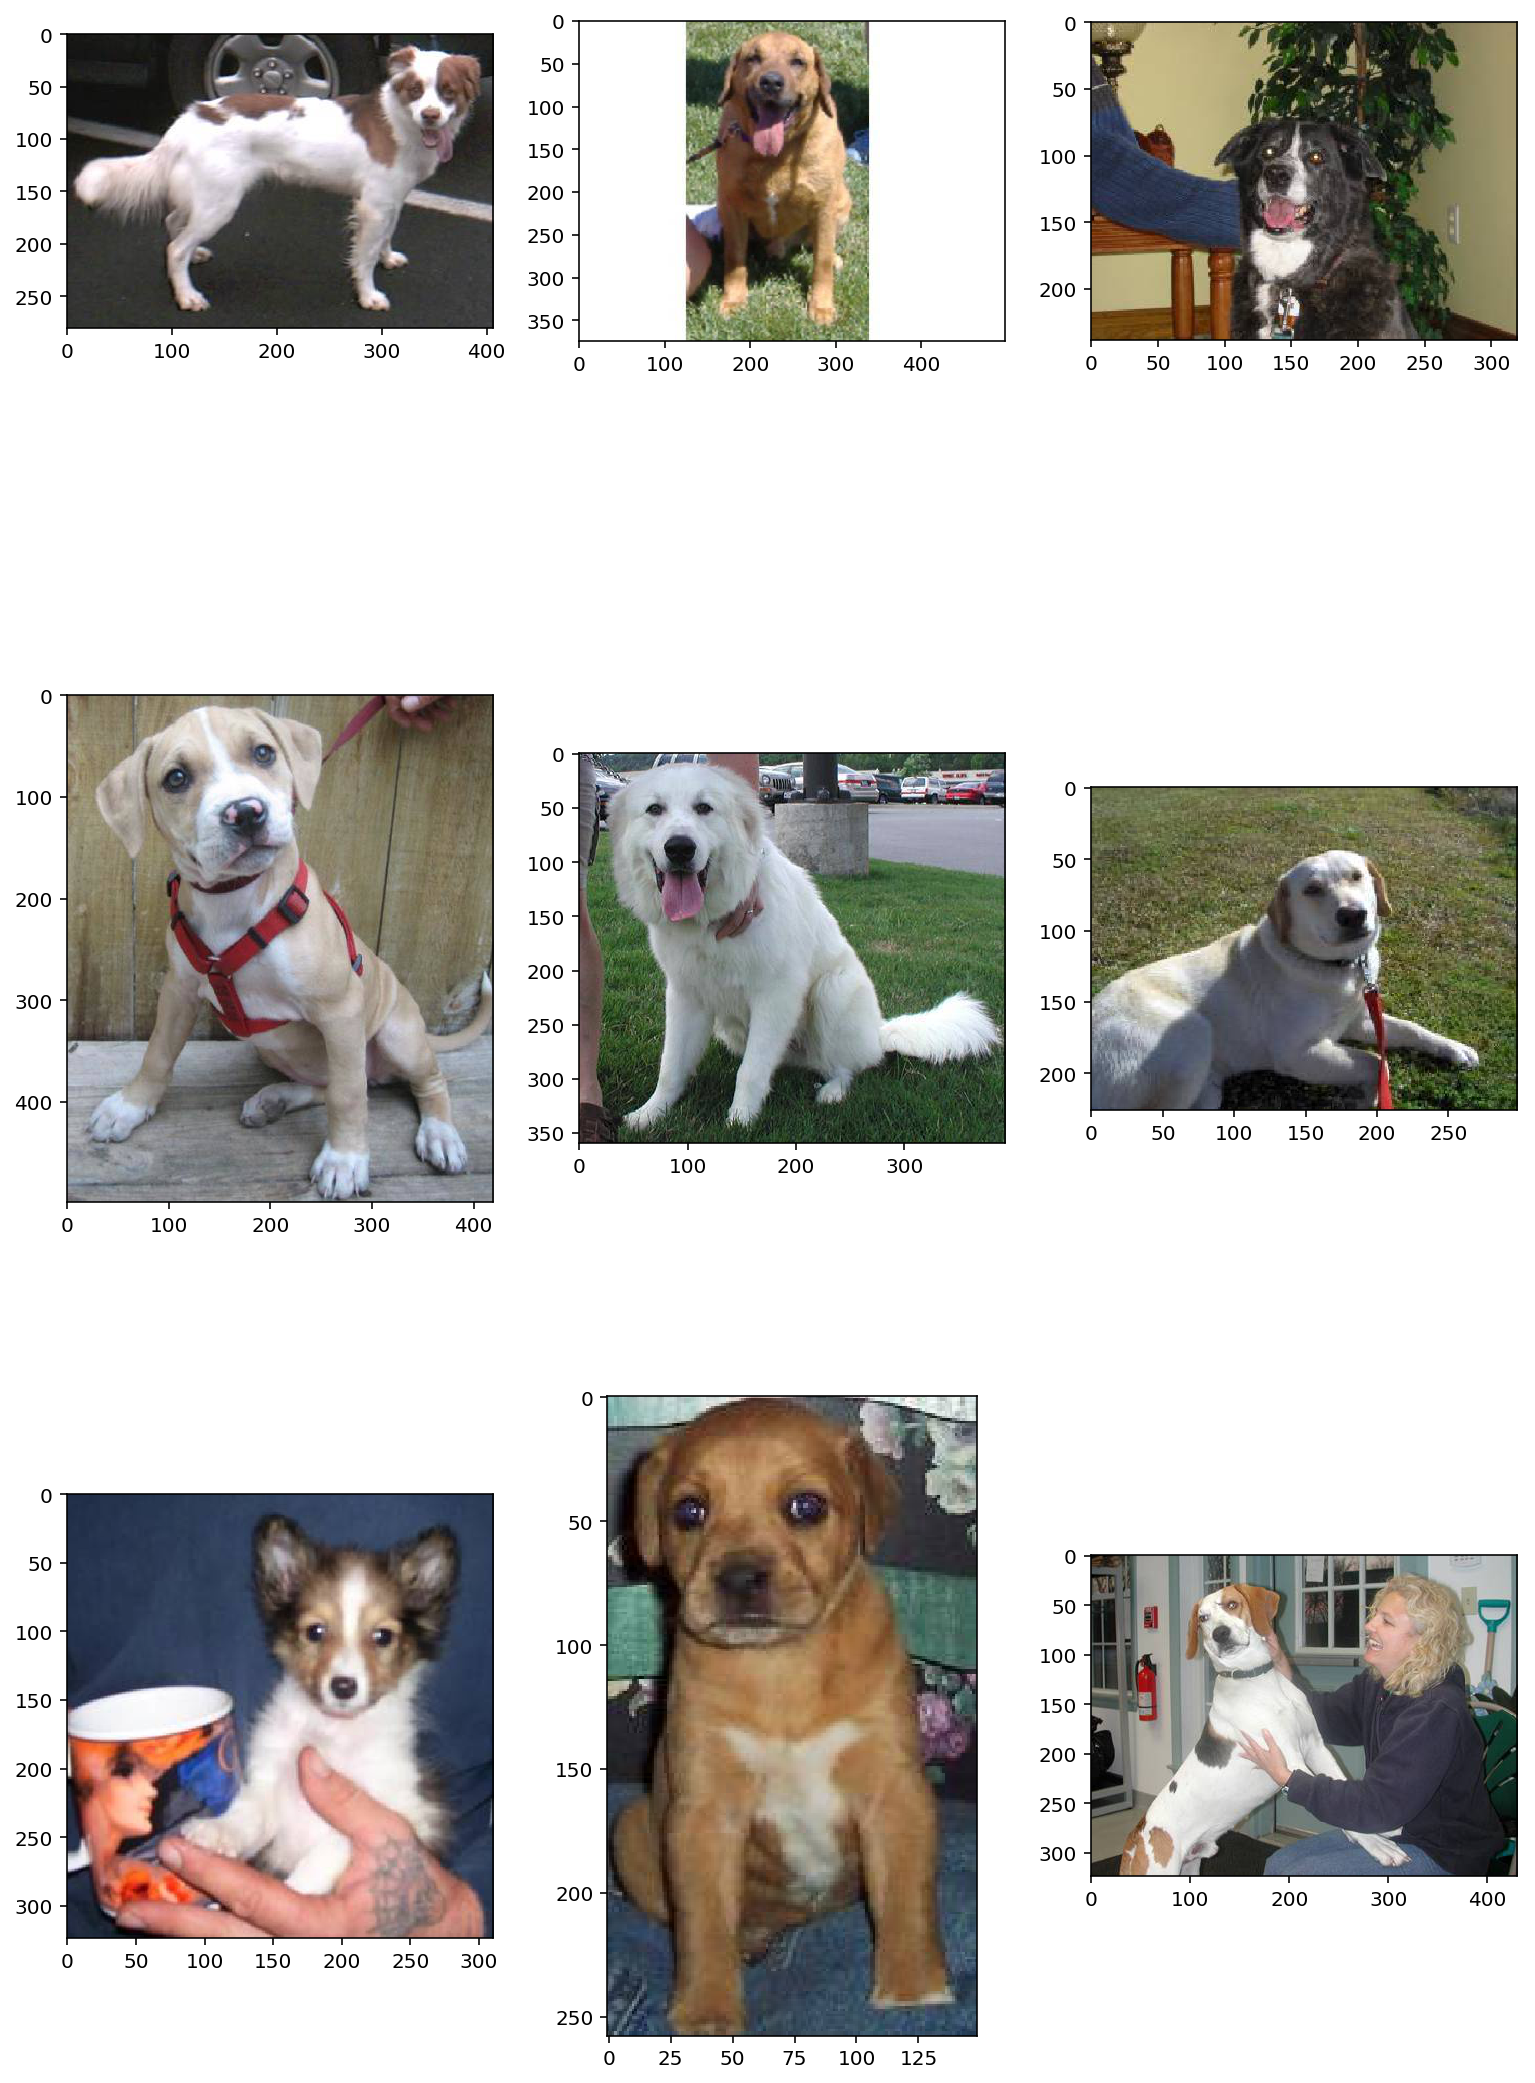

In [36]:
plt.figure(1, figsize=(13, 20))
for i, img_path in enumerate(dog_image_paths, 1):
    plt.subplot(3, 3, i)
    imgplot = plt.imshow(load_img(img_path))

plt.show()

In [37]:
images = np.array([
    img_to_array(load_img(img_path, target_size=(150, 150))) * 1./255
    for img_path in cat_image_paths + dog_image_paths
])

In [38]:
df = pd.DataFrame({
    "class": ["cat" if i < num_samples else "dog" for i in range(num_samples * 2)]
})
df["label"] = [1 if c == "dog" else 0 for c in df["class"]]

In [50]:
images = np.array([
    img_to_array(load_img(img_path, target_size=(150, 150))) * 1./255
    for img_path in cat_image_paths + dog_image_paths
])

for col, model in models.items():
    df[col] = model.predict(images)
    df[col] = df[col].apply(lambda x: x if x >= 0.5 else 1. - x)

In [51]:
df.round(2)

class  label  from scratch  with augmentation  feature extraction  \
0    cat      0          1.00               1.00                0.99   
1    cat      0          1.00               0.97                0.99   
2    cat      0          0.97               0.98                1.00   
3    cat      0          0.93               0.95                1.00   
4    cat      0          1.00               1.00                1.00   
5    cat      0          0.96               0.53                0.99   
6    cat      0          0.98               0.99                0.66   
7    cat      0          0.95               0.98                0.79   
8    cat      0          0.98               0.98                1.00   
9    dog      1          0.51               0.94                0.95   
10   dog      1          1.00               0.98                0.89   
11   dog      1          1.00               0.74                0.95   
12   dog      1          0.99               0.99                1.00   
13   dog      1          1.00               1.00                1.00   
14   dog      1          0.96               1.00                1.00   
15   dog      1          1.00               0.96                0.56   
16   dog      1          0.97               1.00                1.00   
17   dog      1          0.96               0.69                0.87   

    fe with augmentation  fine tuning  
0                   0.99          1.0  
1                   0.96          1.0  
2                   0.99          1.0  
3                   0.98          1.0  
4                   1.00          1.0  
5                   0.98          1.0  
6                   0.76          1.0  
7                   0.98          1.0  
8                   0.99          1.0  
9                   0.99          1.0  
10                  0.96          1.0  
11                  0.90          1.0  
12                  1.00          1.0  
13                  1.00          1.0  
14                  1.00          1.0  
15                  0.93          1.0  
16                  1.00          1.0  
17                  0.87          1.0

In [31]:
from sklearn.metrics import log_loss

data = {"model": [], "accuracy": [], "cross_entropy": []}
for col in ("from scratch", "with augmentation", "feature extraction", "fe with augmentation", "fine tuning"):
    data["model"].append(col)
    accuracy = (df.label == (df[col] >= 0.5)).sum() / df.shape[0]
    data["accuracy"].append(accuracy)
    cross_entropy = log_loss(df.label, df[col], eps=1e-5)
    data["cross_entropy"].append(cross_entropy)
    
dg = pd.DataFrame(data)

In [32]:
dg.round(2)

model  accuracy  cross_entropy
0          from scratch      0.67           1.38
1     with augmentation      0.89           0.33
2    feature extraction      0.89           0.18
3  fe with augmentation      0.89           0.33
4           fine tuning      0.94           0.64

# Taking a closer look at the loss function

[Sklearn User-Guide](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss)

[Sklearn Apidocs](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)

[Sklearn Source](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/classification.py)

## Naive implementation

$L_{\log}(y, p) = -\log \operatorname{Pr}(y|p) = -(y \log (p) + (1 - y) \log (1 - p))$

In [31]:
%%time
losses = []
for y, p in df[["label", "from scratch"]].values:
    loss = -(y * np.log(p) + (1 - y) * np.log(1 - p))
    losses.append(loss)
log_loss = sum(losses) / len(losses)
print(log_loss)

1.4704503410329246
CPU times: user 5.33 ms, sys: 2.62 ms, total: 7.95 ms
Wall time: 8.94 ms


## Optimized version (like sklearn, but simplified)

In [32]:
%%time
y = df.label.values.reshape(-1, 1)
y = np.append(1 - y, y, axis=1)

p = df["from scratch"].values.reshape(-1, 1)
p = np.clip(p, 1e-5, 1 - 1e-5)
p = np.append(1 - p, p, axis=1)
p /= p.sum(axis=1)[:, np.newaxis]

log_loss = np.average(-(y * np.log(p)).sum(axis=1))
print(log_loss)

1.4704514091345118
CPU times: user 1.72 ms, sys: 425 µs, total: 2.14 ms
Wall time: 2.05 ms
